In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

# Default data type for tensorflow tensors.
dtype = tf.float64

2023-02-05 19:31:11.146474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
# Thanks to Dave Moore for extending this to work with batch dimensions!
# This turns out to be necessary for ADVI to work properly.
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = tf.math.cumprod(1 - v, axis=-1)
    one_v = tf.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], "CONSTANT", constant_values=1)
    c_one = tf.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims + [[1, 0]], "CONSTANT", constant_values=1)
    return one_v * c_one

# Example:
# stickbreak(np.random.rand(2, 3))  # Last dimension is the number of sticks breaks.
# Returns a tensor of shape(2, 4).
#
# stickbreak(np.random.rand(2, 3, 4))  # Last dimension is the number of sticks breaks.
# Returns a tensor of shape(2, 3, 5).
#
# The last dimensions sum to 1.
# stickbreak(np.random.randn(2,3,4)).numpy().sum(-1)

In [4]:
# See: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily
# See: https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model
def create_dp_sb_gmm(nobs, K, dtype=np.float64):
    return tfd.JointDistributionNamed(dict(
        # Mixture means
        mu = tfd.Independent(
            tfd.Normal(np.zeros(K, dtype), 3),
            reinterpreted_batch_ndims = 1, 
            ),
        # Mixture scales
        sigma = tfd.Independent(
            tfd.LogNormal(loc=np.full(K, - 2, dtype), scale=0.5),
            reinterpreted_batch_ndims = 1,
            ),
        # Mixture weights (stick-breaking construction)
        alpha = tfd.Gamma(concentration=np.float64(1.0), rate=10.0),
        v = lambda alpha: tfd.Independent(
            # NOTE: Dave Moore suggests doing this instead, to ensure 
            # that a batch dimension in alpha doesn't conflict with 
            # the other parameters.
            tfd.Beta(np.ones(K - 1, dtype), alpha[..., tf.newaxis]),
            reinterpreted_batch_ndims=1
        ),
        # Observations (likelihood)
        obs = lambda mu, sigma, v: tfd.Sample(tfd.MixtureSameFamily(
            # This will be marginalized over.
            mixture_distribution=tfd.Categorical(probs=stickbreak(v)),
            components_distribution=tfd.Normal(mu, sigma)),
            sample_shape=nobs)
    ))

# Example usages:
# dp_sb_gmm = create_dp_sb_gmm(13, 5)
# sample = dp_sb_gmm.sample()
# dp_sb_gmm.log_prob(**sample)
# print(dp_sb_gmm.resolve_graph())
# print(sample)
#
# dp_sb_gmm.log_prob(mu=tfd.Normal(np.float64(0), 1).sample(5),
#                    sigma=tfd.Uniform(np.float64(0), 1).sample(5),
#                    alpha=tf.cast(1, dtype),
#                    v=tfd.Beta(np.float64(1), 1).sample(5 - 1),
#                    obs=np.random.randn(1000))

In [5]:
# Make sure that `model.sample()` AND `model.sample(N)` works for N > 1!
# create_dp_sb_gmm(13, 5).sample()
# create_dp_sb_gmm(13, 5).sample((1,2))

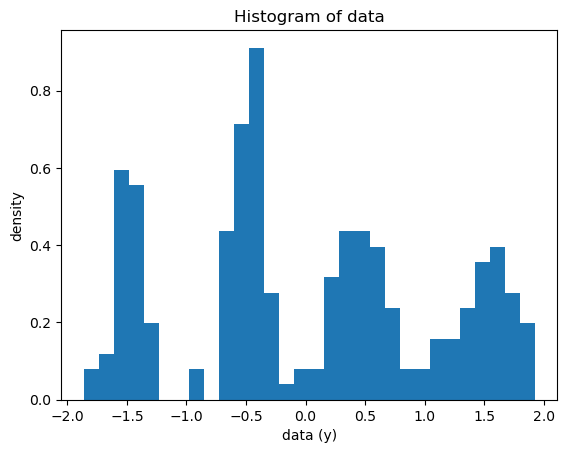

In [7]:
# Read simulated data.
path_to_data = './data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)

# Give data the correct type.
y = np.array(simdata['y'], dtype=np.float64)

# Plot histogram of data.
plt.hist(y, density=True, bins=30)
plt.xlabel('data (y)')
plt.ylabel('density')
plt.title('Histogram of data');

In [8]:
# Helper for plotting posterior distribution of a given parameter.
def plot_param_post(param, param_name, param_full_name, level=95, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    
    ci_lower = (100 - level) / 2
    ci_upper = (100 + level) / 2

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[ci_lower, ci_upper], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [9]:
# Helper for plotting posterior distribution of all model parameters.
def plot_all_params(output, target_logprob_fn):
    mu = output['mu'].numpy()
    sigma = output['sigma'].numpy()
    v = output['v']
    alpha = output['alpha'].numpy()
    eta = stickbreak(v).numpy()
    
    plot_param_post(eta, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(mu, 'mu', 'mixture locations', truth=simdata['mu'])
    plot_param_post(sigma, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(alpha, bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha"); 
    
    plt.subplot(1, 2, 2)
    # Plot log joint posterior (unnormalized)
    lp = [target_logprob_fn(mu=mu[i], sigma=sigma[i], alpha=alpha[i], v=v[i]) for i in range(len(mu))]
    lp = np.vstack(lp).ravel()
    plt.plot(lp)
    plt.xlabel("iteration (post-burn)")
    plt.ylabel("log joint posterior density (unnormalized)");

In [10]:
# Number of mixture components.
ncomponents = 10

print('Create model ...')
model = create_dp_sb_gmm(nobs=len(simdata['y']), K=ncomponents)

# This allows the model to figure out dimensions of prob vector. 
_ = model.sample()

print('Define log unnormalized joint posterior density ...')
def target_log_prob_fn(mu, sigma, alpha, v):
    return model.log_prob(obs=y, mu=mu, sigma=sigma, alpha=alpha, v=v)

Create model ...


2023-02-05 19:31:57.558531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 19:31:57.559689: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Define log unnormalized joint posterior density ...


In [11]:
# This cell contains everything for initializing the 
# variational distribution, which approximates the true posterior.
# ADVI is quite sensitive to initial distritbution.
tf.random.set_seed(7) # 7

# Create variational parameters.
qmu_loc = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64) * 3, name='qmu_loc')
qmu_rho = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64) * 2, name='qmu_rho')

qsigma_loc = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64) - 2, name='qsigma_loc')
qsigma_rho = tf.Variable(tf.random.normal([ncomponents], dtype=np.float64) - 2, name='qsigma_rho')

qv_loc = tf.Variable(tf.random.normal([ncomponents - 1], dtype=np.float64) - 2, name='qv_loc')
qv_rho = tf.Variable(tf.random.normal([ncomponents - 1], dtype=np.float64) - 1, name='qv_rho')

qalpha_loc = tf.Variable(tf.random.normal([], dtype=np.float64), name='qalpha_loc')
qalpha_rho = tf.Variable(tf.random.normal([], dtype=np.float64), name='qalpha_rho')

# Create variational distribution.
surrogate_posterior = tfd.JointDistributionNamed(dict(
    # qmu
    mu=tfd.Independent(tfd.Normal(qmu_loc, tf.nn.softplus(qmu_rho)), reinterpreted_batch_ndims=1),
    # qsigma
    sigma=tfd.Independent(tfd.LogNormal(qsigma_loc, tf.nn.softplus(qsigma_rho)), reinterpreted_batch_ndims=1),
    # qv
    v=tfd.Independent(tfd.LogitNormal(qv_loc, tf.nn.softplus(qv_rho)), reinterpreted_batch_ndims=1),
    # qalpha
    alpha=tfd.LogNormal(qalpha_loc, tf.nn.softplus(qalpha_rho))))

In [12]:
# Run optimizer
# @tf.function(autograph=False) , experimental_compile=True)  # Makes slower?
def run_advi(optimizer, sample_size=1, num_steps=2000, seed=1):
    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=surrogate_posterior,
        optimizer=optimizer,
        sample_size=sample_size,
        seed=seed, num_steps=num_steps)  # 200, 2000

opt = tf.optimizers.Adam(learning_rate=1e-2)
%time losses = run_advi(opt, sample_size=1)

CPU times: user 3.11 s, sys: 38.3 ms, total: 3.15 s
Wall time: 2.81 s


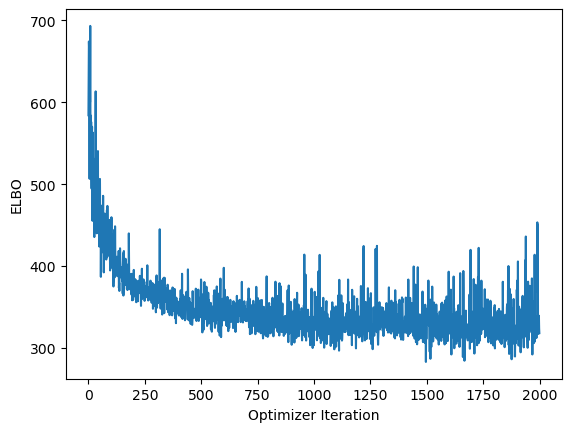

In [13]:
plt.plot(losses.numpy())
plt.xlabel('Optimizer Iteration')
plt.ylabel('ELBO');

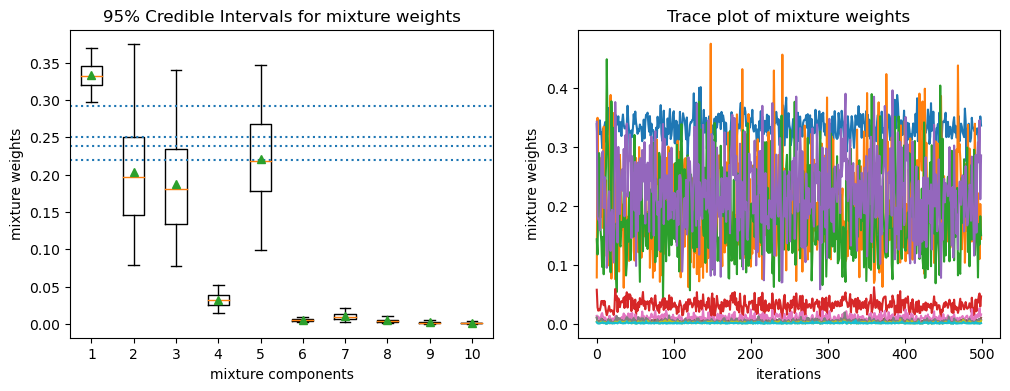

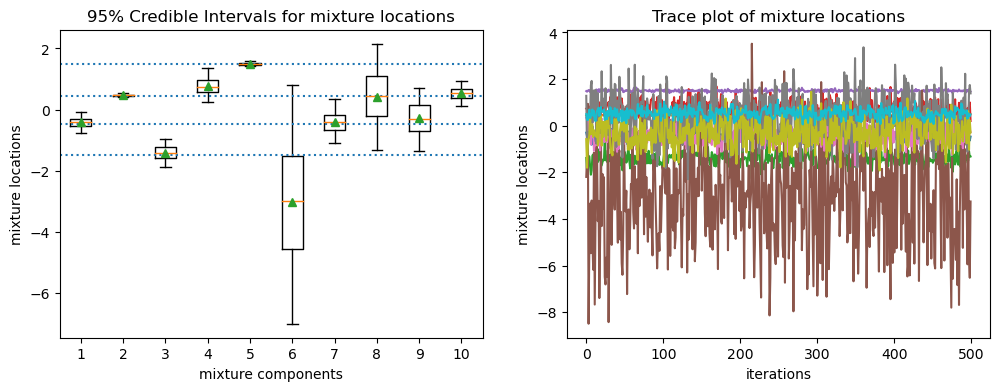

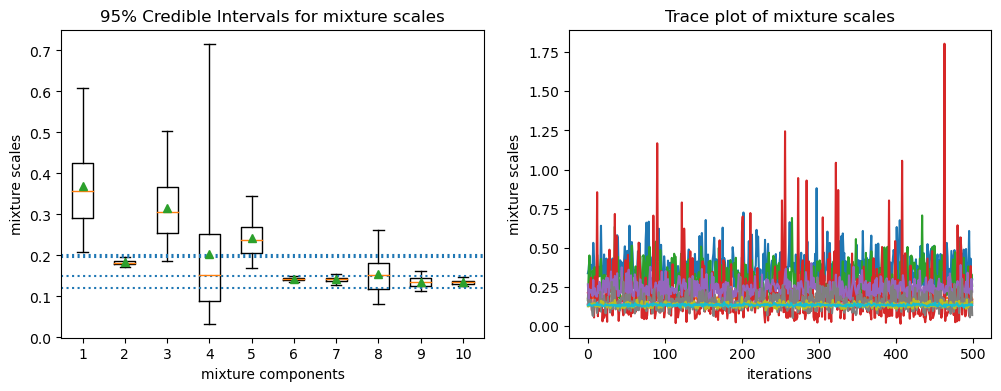

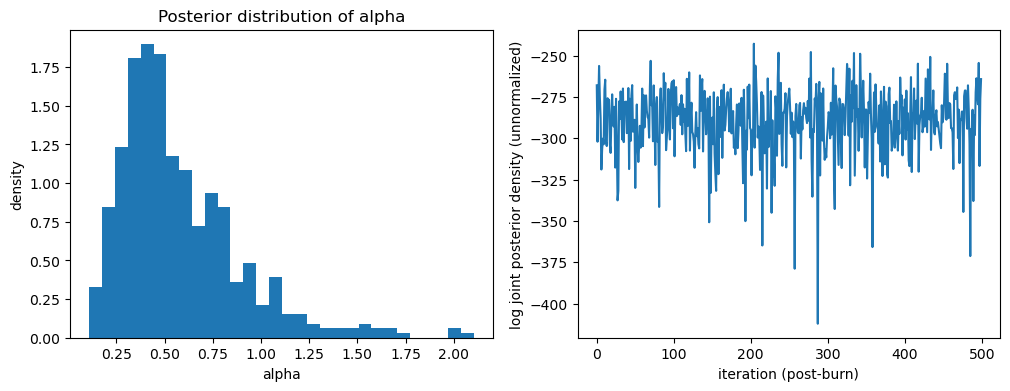

In [14]:
# Extract posterior samples from VI
advi_output = surrogate_posterior.sample(500)
plot_all_params(advi_output, target_log_prob_fn)